# Mining Kickstarter Data: Analysis and Prediction

<img src="https://vignette.wikia.nocookie.net/tomba/images/2/20/Kickstarter-logo.png/revision/latest?cb=20151211134237">

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading / Preprocessing

Let's load the data and see what type of features we're dealing with.

In [228]:
#The last few columns of the CSV from Kaggle are blank, so we'll ignore them
kick = pd.read_csv("ksprojects.csv", usecols=range(13))

In [229]:
kick.dtypes

ID                 int64
name              object
category          object
main_category     object
currency          object
deadline          object
goal              object
launched          object
pledged           object
state             object
backers           object
country           object
usd pledged       object
dtype: object

In [230]:
kick.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375


There's a bunch of whitespace in a few of the column heads, so we'll need to remove that first.

In [231]:
kick.rename(columns=lambda x: x.strip(), inplace=True)

Let's also convert some of the date/numeric columns to their proper data type.

There seems to be a few rows that weren't entered correctly, and we need to remove them. We can set the error parameter in the pd.to_datetime or pd.to_numeric functions to coerce, which will set the value as NaN. Then we can remove all Null values from the dataframe.

In [232]:
#Convert the deadline and launched dates to datetime objects
kick['deadline'] = pd.to_datetime(kick['deadline'], errors='coerce')
kick['launched'] = pd.to_datetime(kick['launched'], errors='coerce')

In [233]:
#Convert the goal, pledged, and backers columns to numeric
kick['goal'] = pd.to_numeric(kick['goal'], errors='coerce')
kick['pledged'] = pd.to_numeric(kick['pledged'], errors='coerce')
kick['usd pledged'] = pd.to_numeric(kick['usd pledged'], errors='coerce')
kick['backers'] = pd.to_numeric(kick['backers'], errors='coerce')

In [234]:
#Check that everything worked smoothly
kick.dtypes

ID                        int64
name                     object
category                 object
main_category            object
currency                 object
deadline         datetime64[ns]
goal                    float64
launched         datetime64[ns]
pledged                 float64
state                    object
backers                 float64
country                  object
usd pledged             float64
dtype: object

In [235]:
#Now, drop all of the rows that have NaN in them
print("Pre-drop: " + str(len(kick)))
kick.dropna(inplace=True)
print("Post-drop: " + str(len(kick)))

Pre-drop: 323750
Post-drop: 319324


## Basic Analysis and Visualization

Before running prediction, let's explore the data. We'll start with some summary visualizations.

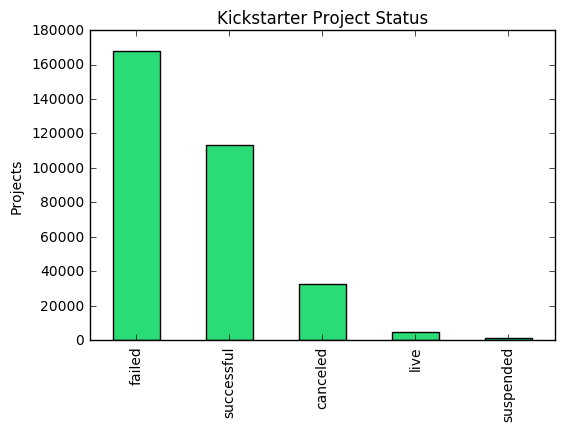

In [236]:
#Distribution of project status
kick['state'].value_counts().plot(kind='bar', color='#2ADC75')
plt.title('Kickstarter Project Status')
plt.ylabel('Projects')

In this dataset, the plurality of projects failed, and a non-trivial amount were cancelled. Very few are live or suspended.

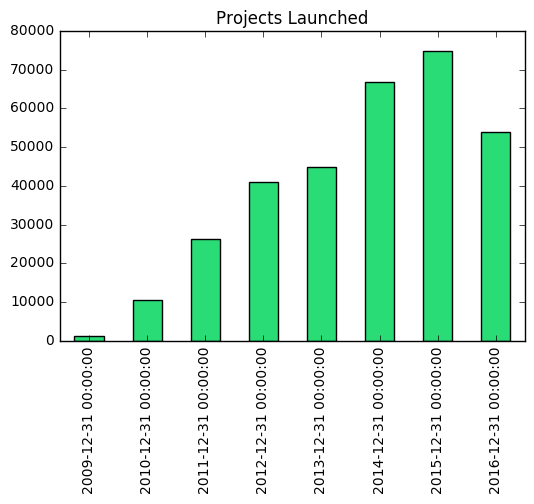

In [274]:
#Projects over time
kickTime = kick.copy()
kickTime.set_index('launched', inplace=True)
grouped = kickTime.resample("A").agg({'ID': np.size})
grouped.iloc[len(grouped)-8:len(grouped)].plot(kind='bar', color='#2ADC75', legend=None)
plt.title('Projects Launched')
plt.xlabel('')

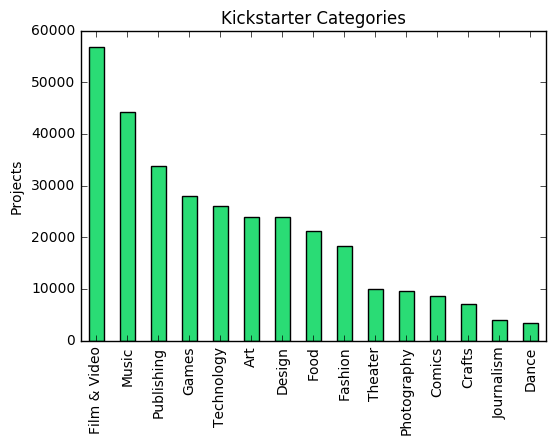

In [11]:
#Distribution of main categories
kick['main_category'].value_counts().plot(kind='bar', color='#2ADC75')
plt.title('Kickstarter Categories')
plt.ylabel('Projects')

The arts (Film, Video, Music) are the most popular categories. Technology is only 5th, which is surprising given how much those kinds of projects grab the news headlines.

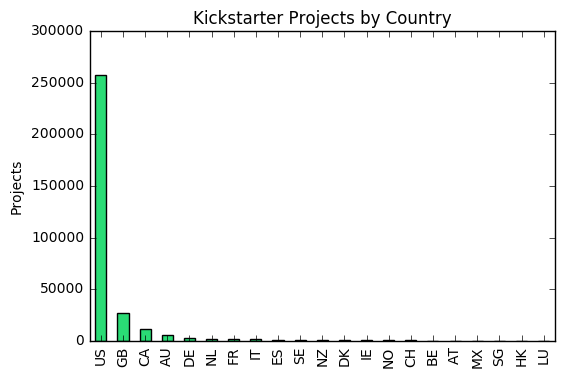

In [12]:
#Distribution of countries
kick['country'].value_counts().plot(kind='bar', color='#2ADC75')
plt.title('Kickstarter Projects by Country')
plt.ylabel('Projects')

English speaking companies totally dominate. 

In [13]:
#Distribution of goals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
kick['goal'].describe()

count      319324.00
mean        47647.73
std       1146310.93
min             0.01
25%          2000.00
50%          5000.00
75%         15000.00
max     100000000.00
Name: goal, dtype: float64

The average goal is around 50K, but the standard deviation is more than 1M – and the median is 5K. Let's check out how these compare to the actual amount pledged.

In [14]:
kick['pledged'].describe()

count     319324.00
mean        8764.17
std        89981.71
min            0.00
25%           30.00
50%          610.00
75%         3939.81
max     20338986.27
Name: pledged, dtype: float64

These numbers are noticeably lower across the board. We can get a sense for how succesful each project generally is by creating a pledged/goal ratio on a per group basis. First, across state:

In [15]:
stateRatio = kick.groupby('state').agg({'pledged': np.mean, 'goal': np.mean})
stateRatio['ratio'] = stateRatio['pledged'] / stateRatio['goal']
stateRatio

,pledged,goal,ratio
state,,,
canceled,2287.62,88041.61,0.03
failed,1369.41,63500.80,0.02
live,11778.96,64125.41,0.18
successful,21480.74,9627.80,2.23
suspended,10485.76,217884.25,0.05


Now, across categories:

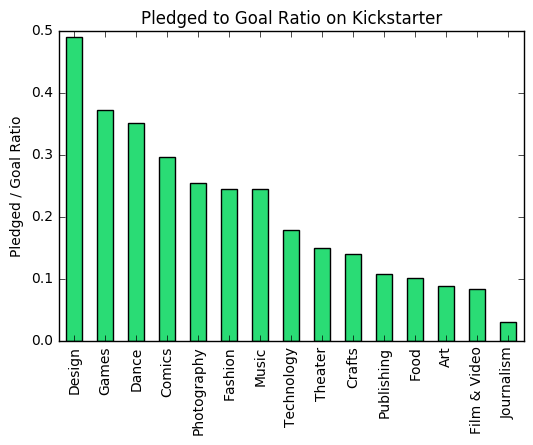

In [16]:
catRatio = kick.groupby('main_category').agg({'pledged': np.mean, 'goal': np.mean})
catRatio['ratio'] = catRatio['pledged'] / catRatio['goal']
catRatio['ratio'].sort_values(ascending=False).plot(kind='bar', color='#2ADC75')
plt.title('Pledged to Goal Ratio on Kickstarter')
plt.xlabel('')
plt.ylabel('Pledged / Goal Ratio')

We can do the same analysis with succesful to failed projects to get a more macro feel for each category.

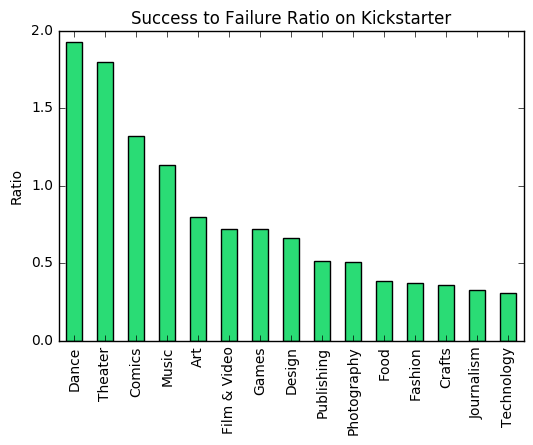

In [17]:
catPivot = kick.pivot_table(index='main_category', columns='state', values='ID', aggfunc='count')
catPivot['WLratio'] = catPivot['successful'] / catPivot['failed']
catPivot['WLratio'].sort_values(ascending=False).plot(kind='bar', color='#2ADC75')
plt.title('Success to Failure Ratio on Kickstarter')
plt.xlabel('')
plt.ylabel('Ratio')

Finally, let's create a comprehensive visualization that maps project outcomes across all categories.

In [18]:
#First, turn our pivot table columns into percentages instead of absolute numbers
catPivot = kick.pivot_table(index='main_category', columns='state', values='ID', aggfunc='count')
catPivot['total'] = catPivot.sum(axis=1)

In [19]:
#Change all columns to percentages of total
for column in catPivot.columns[:5]:
    catPivot[column] = catPivot[column] / catPivot['total']

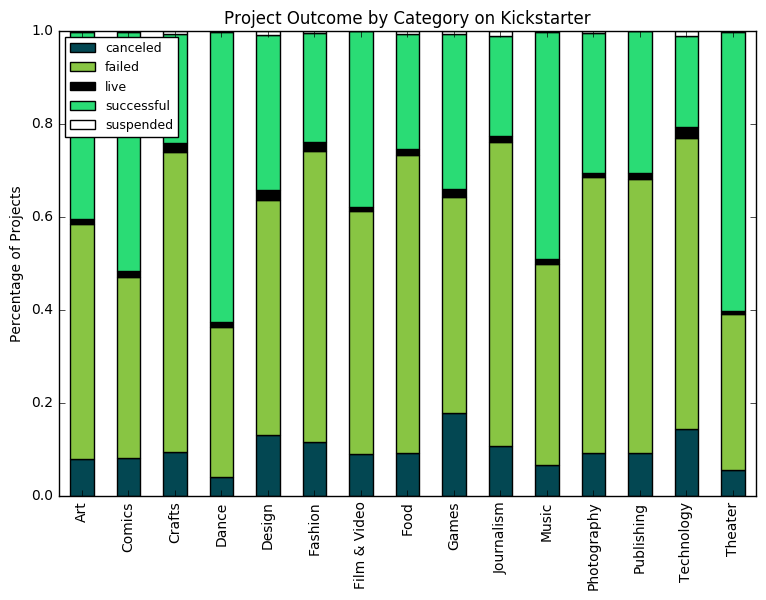

In [20]:
#Plot
catPivot.iloc[:,:5].plot(kind='bar', stacked=True, figsize=(9,6), 
                         color=['#034752', '#88C543', 'black','#2ADC75', 'white'])
plt.title('Project Outcome by Category on Kickstarter')
plt.legend(loc=2, prop={'size': 9})
plt.xlabel('')
plt.ylabel('Percentage of Projects')

## Prediction – What Drives Successful Projects?

Imagine you're starting out on the Kickstarter platform and want to make sure that your project has the highest possible chance of success. What do you do?

There are a number of ways we can approach this as a prediction problem:

* Classification: what drives a "success" in the state column?
* Regression: what drives highest "pledged" values?
* Regression: what drives the highest number of backers?

We'll run through all of these and see what kinds of accuracy we can achieve. Which model is right for any given situation depends on what the creator is optimizing for.

### Classification

Some relevant features might be: 

* category
* main_category
* goal
* country

There's also some potential to mind project names for words that correlate with success. We'll try a few different algorithms and see which gets the best accuracy: Logistic Regression, Decision Trees, and Naive Bayes. 

First, let's encode our categorical variables.

In [60]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

kickML = kick.copy()
for column in ['category', 'main_category','country']:
    kickML[column] = enc.fit_transform(kickML[column])

Since we're really only interested in success, we'll narrow down the dataset to only two outcomes – success and failure.

In [61]:
kickML = kickML[kickML['state'].apply(lambda x: x in ['successful', 'failed'])]

We'll also split the data into train, test, and cross validation sets (70% train, 15% each test and CV).

In [62]:
from sklearn.utils import shuffle
kickML = shuffle(kickML)

In [202]:
def dataSplit(features, target):
    trainx = kickML.iloc[:223526][features]
    trainy = kickML.iloc[:223526][target]
    testx = kickML.iloc[223527:271425][features]
    testy = kickML.iloc[223527:271425][target]
    cvx = kickML.iloc[271426:len(kickML)][features]
    cvy = kickML.iloc[271426:len(kickML)][target]
    
    return trainx, trainy, testx, testy, cvx, cvy

In [204]:
trainx, trainy, testx, testy, cvx, cvy = dataSplit(['category', 'main_category', 'goal', 'country'], 'state')

#### Logistic Regression

We'll start with Logistic Regression.

In [205]:
from sklearn import linear_model
model = linear_model.LogisticRegression()

In [206]:
model.fit(trainx, trainy)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We'll define a function for confusion matrix analysis, since we'll use it a few times.

In [207]:
from sklearn.metrics import confusion_matrix

In [208]:
def printCM(y,y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print("True positives: " + str(tp))
    print("False positives: " + str(fp))
    print("True negatives: " + str(tn))
    print("False negatives: " + str(fn))
    print('\n')
    print("Overall accuracy: " + str((tp+tn)/float((tp+tn+fp+fn))))
    print("Precision (tp/tp+fp): " + str(tp/float((tp+fp))))
    print("Recall (tp/tp+fn): " + str(tp/float((tp+fn))))

In [209]:
printCM(trainy, model.predict(trainx))

True positives: 0
False positives: 0
True negatives: 133826
False negatives: 89700


Overall accuracy: 0.598704401278
Precision (tp/tp+fp): nan
Recall (tp/tp+fn): 0.0


/Users/gagejustins/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


Our model is predicting exclusively "failed." This is strange, and will only leave us with accuracy along the base rate:

In [210]:
kickML['state'].value_counts()['failed'] / float(len(kickML))

0.59807747724030469

Let's try a decision tree (or a few).

#### Decision Trees

In [72]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=10)

In [73]:
clf = clf.fit(trainx, trainy)

In [74]:
printCM(trainy, clf.predict(trainx))

True positives: 43975
False positives: 28103
True negatives: 105723
False negatives: 45725


Overall accuracy: 0.669711800864
Precision (tp/tp+fp): 0.610102944033
Recall (tp/tp+fn): 0.490245261984


Training accuracy is a respectable 67%, but both precision and recall are lower than that number.

In [75]:
printCM(cvy, clf.predict(cvx))

True positives: 1907
False positives: 1215
True negatives: 4543
False negatives: 1998


Overall accuracy: 0.667494566905
Precision (tp/tp+fp): 0.610826393338
Recall (tp/tp+fn): 0.488348271447


Accuracy on the cross validation set is less encouraging. Let's try an ensemble model.

In [76]:
from sklearn.ensemble import RandomForestClassifier
clfF = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=10)

In [77]:
clfF.fit(trainx, trainy)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [78]:
printCM(cvy, clfF.predict(cvx))

True positives: 185
False positives: 63
True negatives: 5695
False negatives: 3720


Overall accuracy: 0.608506674946
Precision (tp/tp+fp): 0.745967741935
Recall (tp/tp+fn): 0.0473751600512


This classifier has a lower overall accuracy than the single tree, but a 13% point higher precision. The recall has dropped from 47% to just 4% though, as there's a very high proportion of false negatives. In fact the number of positives predicted dropped from 1849 to 160, so this model is much more conservative.

#### Naive Bayes

Let's try a classic, the Naive Bayes Classifier.

In [79]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [80]:
printCM(trainy, gnb.fit(trainx, trainy).predict(trainx))

True positives: 88652
False positives: 125223
True negatives: 8603
False negatives: 1048


Overall accuracy: 0.435094798815
Precision (tp/tp+fp): 0.414503798948
Recall (tp/tp+fn): 0.988316610925


Overall accuracy is much lower than other models, but recall is extremely high with a value of 99%. The same holds true for the test set:

In [81]:
printCM(testy, gnb.fit(testx, testy).predict(testx))

True positives: 19166
False positives: 26621
True negatives: 1906
False negatives: 205


Overall accuracy: 0.439934861581
Precision (tp/tp+fp): 0.418590429598
Recall (tp/tp+fn): 0.989417169996


### Regression

The feature set should be largely similar, but instead of trying to predict a binary (success/failure) we'll look at a different target variable: money pledged as a percentage of the goal. This is a better target variable than absolute money raised, since it is normalized by the goal.

We'll start by creating a column for percentage of goal achieved to use as our target variable.

In [84]:
kickML['completion'] = kickML['usd pledged'] / kickML['goal']

And now, as above, we'll split our data into train, test, and cross validation.

In [211]:
trainx, trainy, testx, testy, cvx, cvy = dataSplit(['category', 'main_category', 'goal', 'country'], 'completion')

#### Linear Regression

In [212]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import sklearn.metrics
lr = LinearRegression()

In [213]:
model = lr.fit(trainx, trainy)

Let's define a function to analyze metrics for our regressions.

In [214]:
def regScore(trainy, predy):
    print("R^2: " + str(m.r2_score(trainy, predy)))
    print("MSE: " + str(m.mean_squared_error(trainy, predy)))
    print("MAE: " + str(m.mean_absolute_error(trainy, predy)))

In [215]:
regScore(trainy, model.predict(trainx))

R^2: 2.81977833255e-05
MSE: 36751.7911629
MAE: 4.47764829803


An R^2 of sub 1% is not very good. Let's take a look at the coefficients and their significance levels:

In [216]:
pd.DataFrame({'coefficient': model.coef_, 
              'F-score': f_regression(trainx, trainy)[0], 
              'p-value': f_regression(trainx, trainy)[1]},
            index = trainx.columns)

,F-score,coefficient,p-value
category,3.02,0.02,0.08
main_category,0.01,-0.05,0.92
goal,0.07,-0.00,0.80
country,2.97,0.13,0.08


The category and country features have p-values of .08, which is slightly above the traditional .05 threshold but still means that they have non-trivial predictive power for completion. Interestingly enough, the size of the goal has no impact on whether it will be achieved or not.

#### Decision Tree

In [217]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=5)

In [218]:
dtr.fit(trainx, trainy)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [141]:
regScore(trainy, dtr.predict(trainx))

R^2: 0.218141739605
MSE: 28735.5017825
MAE: 3.45426539685


This decision tree achieves a much better R^2 of 22%. We can also try a random forest:

In [143]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

In [144]:
rfr.fit(trainx, trainy)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [146]:
regScore(trainy, rfr.predict(trainx))

R^2: 0.249429673182
MSE: 27585.5817566
MAE: 3.09703692624


Looks like the Random Forest Regressor achieves the highest overall R^2. Let's plot how our key metrics change as we vary the max_depth parameter in this decision tree.

In [197]:
def graphRFRR2(trainx, trainy):
    
    #For adjusting max_depth
    rsmax_depth = []
    for depth in np.arange(2,112, 10):
        rfr = RandomForestRegressor(max_depth=depth)
        rsmax_depth.append(m.r2_score(trainy, rfr.fit(trainx, trainy).predict(trainx)))
        
    #For adjusting max_lead_nodes
    rsmax_leaf_nodes = []
    for nodes in np.arange(2,112, 10):
        rfr = RandomForestRegressor(max_leaf_nodes=nodes)
        rsmax_leaf_nodes.append(m.r2_score(trainy, rfr.fit(trainx, trainy).predict(trainx)))
   
    return pd.DataFrame({'max_depth': rsmax_depth, 'max_leaf_nodes': rsmax_leaf_nodes}, index=np.arange(2,112,10))

In [198]:
plotR = graphRFRR2(trainx, trainy)

(0, 1)

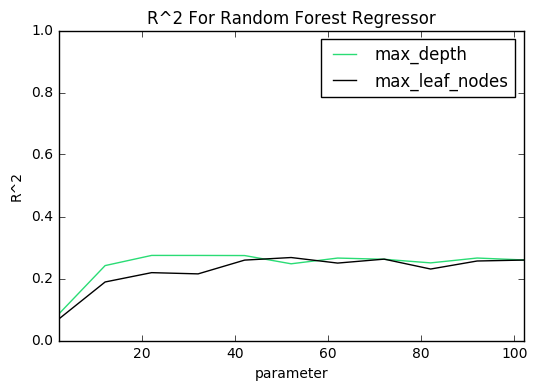

In [201]:
plotR.plot(color=['#2ADC75', 'black'])
plt.title('R^2 For Random Forest Regressor')
plt.xlabel('parameter')
plt.ylabel('R^2')
plt.ylim(0,1)

## Summary / Conclusion

Overall, we weren't able to achieve any measure of great accuracy on our prediction tasks. Our classifier maxed out at around 67%, and our regressions maxed out around an R^2 of 25%.

Some ideas to improve our prediction accuracy across both classification and regression:

* Mine project names for new features
* Gather new informative data like a project description and attached images
* More complex algorithms